In [22]:
%load_ext autoreload
%autoreload 2
     
import torch
import os
from matplotlib import pyplot as plt
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

import os
import torch

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from csng.imagenet.models import ReadIn, ResnetExtractor, UpsampleModel
import datetime

assert torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

device = os.environ["DEVICE"]
DATA_PATH = os.environ['DATA_PATH']
CACHE_DIR = os.path.join(DATA_PATH, 'brainreader_cache')
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, 'brainreader')

BATCH_SIZE = 64
EPOCHS = 50
WEIGHT_DECAY=0e-4
LEARNING_RATE = .0002* BATCH_SIZE
READIN_DTYPE = torch.bfloat16
MODEL_PATH = '/scratch/izar/vanousek/cs-433-project/models/'
RESNET_DECODE_MODEL = os.path.join(MODEL_PATH, 'mlp2489100.pt')

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [24]:
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "encoder_ball_50.pt"),
    # "load_ckpt": os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    "train": True,
}
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": BATCH_SIZE,
    # "sessions": list(range(1, 23)),
    "sessions": [1],
    "resize_stim_to": (224, 224),
    "normalize_stim": False,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": True,
    "additional_keys": None,
    "avg_test_resp": True,
}

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
print(len(dl['train']), len(dl['test']))

71 2


1
torch.Size([64, 1, 224, 224])
torch.Size([64, 9395])
1


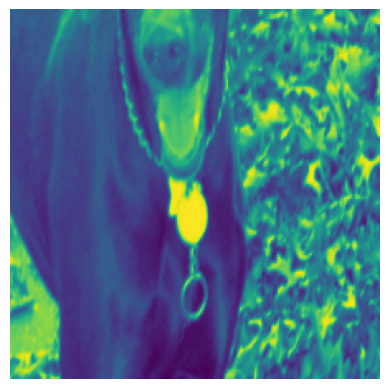

In [25]:
def show_image(img_tensor, title=''):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

items = next(dl['train'])
print(len(items))
item = items[0]
stim = item['stim']
print(stim.shape)

resp = item['resp']
print(resp.shape)
neurons = resp.shape[1]
data_key = item['data_key']
print(data_key)
# plot the stim as grayscale image with matplotlib
show_image(stim[0]) 


In [26]:
import torch
from torch.nn import functional as F





readin = ReadIn(neurons, (1024, 14, 14))
readin.to(device, dtype=READIN_DTYPE)
    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(readin)
print("Total parametrs: ", params)

Total parametrs:  240616448


In [ ]:

optimizer = torch.optim.Adam(readin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dl['train'])*EPOCHS, eta_min=LEARNING_RATE/5)

extractor = ResnetExtractor()

losses = []


for epoch in range(EPOCHS):
    dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
    for minibatch in tqdm(dl['train']):
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)

        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        
        with torch.cuda.amp.autocast():
            pass
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)
        output = readin(resp)
        loss = criterion(output, target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(readin.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)
        losses.append(relative_loss)
        # print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")

        optimizer.zero_grad()
    print(f"Epoch {epoch} finished with relative loss {np.mean(losses[-len(dl['train']):])}")



Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
  0%|                                                                                        | 0/71 [00:00<?, ?it/s]/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████████████████████████████████████████████████████████████████████████▉ | 70/71 [01:25<00:01,  1.09s/it]/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 20, 1024, 14, 14])) that is different to the input size (torch.Size([20, 1024, 14, 14])). This will likely lead to incorrect results due

Epoch 0 finished with relative loss 3.8160445792919875


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.32it/s]


Epoch 1 finished with relative loss 0.37771066366478456


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 2 finished with relative loss 0.22079966000082143


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 3 finished with relative loss 0.21060619126819322


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 4 finished with relative loss 0.2036263213177239


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 5 finished with relative loss 0.19769821374011462


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 6 finished with relative loss 0.19076034942895


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 7 finished with relative loss 0.18485611276770414


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 8 finished with relative loss 0.17888610806307384


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 9 finished with relative loss 0.1727490460516206


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 10 finished with relative loss 0.16655309489158554


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 11 finished with relative loss 0.16036522369495174


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 12 finished with relative loss 0.15454035987083525


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 13 finished with relative loss 0.14949641112754875


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 14 finished with relative loss 0.1445924513554085


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 15 finished with relative loss 0.13985037493635516


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 16 finished with relative loss 0.13548006771415136


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 17 finished with relative loss 0.13118469781609438


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 18 finished with relative loss 0.12711674160431355


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 19 finished with relative loss 0.12319135524715631


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 20 finished with relative loss 0.11979747190322436


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 21 finished with relative loss 0.11612677255019938


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 22 finished with relative loss 0.11238350594774764


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 23 finished with relative loss 0.1092933355740964


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 24 finished with relative loss 0.10624888715014844


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 25 finished with relative loss 0.10356627871910157


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 26 finished with relative loss 0.10102433681088781


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 27 finished with relative loss 0.09831855432701489


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 28 finished with relative loss 0.09600020505363017


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 29 finished with relative loss 0.0938908781450062


 17%|█████████████▎                                                                 | 12/71 [00:03<00:17,  3.29it/s]

Epoch 33 finished with relative loss 0.08638980158643232


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 34 finished with relative loss 0.08469447687810917


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.31it/s]


Epoch 35 finished with relative loss 0.08361615970234823


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 36 finished with relative loss 0.0824989163303522


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 37 finished with relative loss 0.08108326222132226


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 38 finished with relative loss 0.08012223536061953


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 39 finished with relative loss 0.07943670260945525


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 40 finished with relative loss 0.07844780039451263


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 41 finished with relative loss 0.07760302375343067


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 42 finished with relative loss 0.07723432034395349


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 43 finished with relative loss 0.07677129449965718


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 44 finished with relative loss 0.07612235691992297


100%|████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 45 finished with relative loss 0.07551493970049647


100%|████████████████████| 71/71 [00:21<00:00,  3.30it/s]


Epoch 46 finished with relative loss 0.07501900145294015


100%|████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 47 finished with relative loss 0.07452681504704241


100%|████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 48 finished with relative loss 0.07426470693126075


100%|████████████████████| 71/71 [00:21<00:00,  3.30it/s]

Epoch 49 finished with relative loss 0.07391754552681885


In [616]:
model_path = os.path.join(MODEL_PATH, "readin", str(datetime.datetime.now()) + ".pt")
if readin is None:
    # Load last model
    readin = torch.load(os.dirlist(MODEL_PATH + "readin")[-1])
    print(f"Loaded model from {model_path}")

else:
    print(f"Saving model to {model_path}")
    torch.save(readin,model_path)

# Plot losses
plt.plot(losses)
plt.yscale('log')

plt.title('Loss (Relative to constant loss)')
plt.xlabel('Batch')


Saving model to /scratch/izar/vanousek/cs-433-project/models/readin/2024-12-16 16:19:15.588554.pt


RuntimeError: Parent directory /scratch/izar/vanousek/cs-433-project/models/readin does not exist.

In [617]:
# Evaluate the model
readin.eval()
test_losses = []
imgs = []
imgnet_activations_real = []
imgnet_activations_pred = []

with torch.no_grad():
    for minibatch in dl['test']:
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)
        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

        output = readin(resp)

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)

        test_losses.append(relative_loss)
        imgnet_activations_real.append(target)
        imgnet_activations_pred.append(output)
        imgs.append(stim)

        print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")
        print(f"Loss: {loss.item()}")
# .22
print(f"Mean loss: {np.mean(test_losses)}")
print(f"Std loss: {np.std(test_losses)}")

/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0096435546875 Constant loss: 0.1162109375 Relative loss: 0.08298247920959066
Loss: 0.0096435546875
Loss: 0.0096435546875 Constant loss: 0.1181640625 Relative loss: 0.08161087959057273
Loss: 0.0096435546875
Mean loss: 0.0822966794000817
Std loss: 0.0006857998095089676


/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 36, 1024, 14, 14])) that is different to the input size (torch.Size([36, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:

output_model = torch.load(RESNET_DECODE_MODEL)
output_model.eval()
for real, recon, pred in zip(imgs, imgnet_activations_real, imgnet_activations_pred):
    plt.figure()
    with torch.no_grad():
        real_img = output_model(real.to('cuda', dtype=torch.float32).squeeze()).squeeze()
        print(real_img.shape)
        for i in range(1, 10):
            plt.figure()
            print(real_img.shape)
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            pred_img = output_model(pred.to('cuda', dtype=torch.float32)).squeeze()
            plt.figure()
            plt.imshow(pred_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.show()

NameError: name 'imgs' is not defined